# Data Analysis Workshop

## Tutorial I: data queries, dataset catalog creation

<div style="border-left: 4px solid #0366d6; padding: 0.5em; background-color: #deecfc;">
  ℹ️ If you want to know more about these topics please refer to:
  <ul>
  <li><code>freva_client</code> library <a href='https://example.com' target="_blank">installation</a></li>
  <li>Databrowser <a href="https://freva-org.github.io/freva-nextgen/databrowser/python-lib.html">python module </a></li>
</ul>  
</div>



In this tutorial, we'll learn how to use the `freva_client` library to explore and access available datasets and at the end customize the dataset on Freva to our own liking.

First let's see how to install the freva client library:

## Installation:

#### The Client Library

| Environment | Installation Command |
|-------------|---------------------|
| DKRZ/Levante (Recommended) | `$ module load clint gems` |
| Conda (Local) | $ `conda create -n freva-client-env -c conda-forge freva-client -y` |
| Python (Local) | `$ pip install freva-client` |


<div style="
  border-left: 6px solid rgb(236, 114, 0);
  background-color:rgb(253, 231, 157);
  color:rgb(19, 19, 18);
  padding: 1em;
  font-size: 110%;
  border-radius: 4px;
  margin: 1em 0;
">
⚠️ <strong>ATTENTION</strong>: For the Freva Databrowser workshop, please open a Terminal tab in Jupyter and write the following:
<pre><code>$ module load clint gems
$ da-workshop-setup
</code></pre>

<br>
And then from kernel environment list, please choose, <code>DA Workshop (python)</code>
Now your environment is ready to start!

</div>

Let quickly ckeck if `freva_client` is available on our current kernel environment!

In [1]:
from freva_client import databrowser, __version__
print(__version__)

2508.0.0


## Querying data:

To get started, we'll run a simple analysis on the [MPI Grand Ensemble data](https://mpimet.mpg.de/en/research/modeling/grand-ensemble), a large collection of climate simulations. Our goal will be to create an ensemble of global averaged time series of 2 m air temperature.

The data browser organizes metadata in a **tree-like hierarchy**. At the top of this structure is the **`project`** facet (equivalent to the **`mip-era`** for CMIP6 Data Reference Syntax) and then it goes down as it follows:
```
.
├── project
│   ├── product
│   │   ├── institute
│   │   │   ├── model
│   │   │   │   ├── experiment
...
```
These facets are organised as `{key: value}` pairs. First and foremost, let's find out which search keys are available:

In [9]:
keys = list(databrowser.metadata_search().keys())
print(f"facets: {keys}\nnum of facets: {len(keys)}")

facets: ['ensemble', 'experiment', 'institute', 'model', 'product', 'project', 'realm', 'time_aggregation', 'time_frequency', 'variable']
num of facets: 10


Let's assume we know that the Grand-Ensemble data is stored under `mpi-ge` but we don't know whether it's under `project` or `product` etc. The databrowser is here to help. You can simply use the `facet` argument to search for all entries containing a certain value, such as `mpi-ge`.

Let's get the project(s) of all search keys (or facets) that contain `mpi-ge`. We can use the `metadata_search` function for that:

In [10]:
databrowser.metadata_search("mpi-ge")["project"]

['mpi-ge']

Since we want to create a time series of 2 m air temperature we will need to check whether the `tas` (near-surface air temperature) variable is available:

In [11]:
"tas" in databrowser.metadata_search("mpi-ge")["variable"]

True

In the same vein, let's query the available output time frequencies:

In [12]:
databrowser.metadata_search("mpi-ge", variable="tas")["time_frequency"]

['mon']

Now we do have a rough overview of the available data. To access the data we will create a so called `instance` of the databrowser class. We want to cover future scenarios, that is, timesteps from today until 2100.

In [13]:
db = databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12")
db

databrowser(flavour=freva, host=http://nextgems.dkrz.de:7777/api/freva-nextgen/databrowser, multi_version=False, project=mpi-ge, variable=tas, time_frequency=mon, time=2025-01 to 2100-12, time_select=flexible)

To check how many files were found we can apply the `len` function to our instance:

In [14]:
len(db)

602

Just like with the `metadata_search` method we can check the meta data with using `metadata` property. This will give you the metadata search parameters that were used to create the `db` object:

In [15]:
db.metadata["experiment"]

['picontrol', 'rcp26', 'rcp45', 'rcp85']

The `picontrol` experiment is unexpected! Let's check the what is going on. We create a new search and check the files belonging to that search:

In [16]:
pcontrol = databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12", experiment="picontrol")
len(pcontrol)

2

To get the files we can "convert" our search to a list

In [17]:
files = list(pcontrol)
files

['/work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM/piControl/mon/atmos/tas/r001i1850p3/v20190123/tas_Amon_MPI-ESM_piControl_r001i1850p3_210001-219912.nc',
 '/work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM/piControl/mon/atmos/tas/r001i1850p3/v20190123/tas_Amon_MPI-ESM_piControl_r001i1850p3_200001-209912.nc']

Let's do a reverse search, that is, check what meta-data is associated with a file, for that we use the `file=` parameter: 

In [18]:
databrowser.metadata_search(file=files[0])

{'ensemble': ['r001i1850p3'],
 'experiment': ['picontrol'],
 'institute': ['mpi-m'],
 'model': ['mpi-esm'],
 'product': ['output1'],
 'project': ['mpi-ge'],
 'realm': ['atmos'],
 'time_aggregation': ['mean'],
 'time_frequency': ['mon'],
 'variable': ['tas']}

Since we don't want this pre-industrial control run among our selected datasets we will tell the databrowser to ignore it.

We can use the `!` to *not* include a certain value:

In [19]:
db = databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12", experiment="!picontrol")
db.metadata["experiment"]

['rcp26', 'rcp45', 'rcp85']

Now let's create a global time series for each experiment. To do this properly, we need to account for the fact that the grid cells in a latitude-longitude grid do not all represent the same area — they shrink toward the poles. Since `xarray` does not natively apply area weights when computing spatial means, we need to define a helper function that applies cosine-latitude weighting to approximate the true area of each grid cell.

In [20]:
import xarray as xr
import numpy as np
def field_mean(
    data: xr.DataArray,
    lat_name: str = "lat",
    lon_name: str = "lon",
    mean_dims: tuple[str, str] = ("lat", "lon")
) -> xr.DataArray:
    """
    Compute an area-weighted mean over latitude and longitude using cosine latitude weights.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with latitude and longitude coordinates.
    lat_name : str, optional
        Name of the latitude coordinate. Default is "lat".
    lon_name : str, optional
        Name of the longitude coordinate. Default is "lon".
    mean_dims : Sequence[str], optional
        Dimensions over which to compute the mean. Default is ("lat", "lon").

    Returns
    -------
    xr.DataArray
        Area-weighted mean of the input data over the specified dimensions.
    """
    # Extract latitude values
    lat = data[lat_name]

    # Compute cosine of latitude in radians
    weights = np.cos(np.deg2rad(lat))

    # Normalize weights so they sum to 1 (over just lat)
    weights /= weights.sum()

    # Apply weighted mean over specified dimensions
    return data.weighted(weights).mean(dim=mean_dims, keep_attrs=True)

then for the workflow

We can use the search result of the databrowser object to directly open our dataset in xarray:

In [22]:
time_series = {}

for exp in db.metadata["experiment"]:
    
    ensembles = []

    members = sorted(
        databrowser.metadata_search(
            project="mpi-ge",
            variable="tas",
            time_frequency="mon",
            time="2025-01 to 2100-12",
            experiment=exp
        )["ensemble"]
    )

    # Going through all ensemble members might take some time,
    # let's make a cut at 5 member x experiment for demo purposes...
    for num, member in enumerate(members[:5]):
        print(f"Reading {exp} | Ensemble {member} ({num+1}/5)", end="\r")

        ds = xr.open_mfdataset(
            databrowser(
                project="mpi-ge",
                variable="tas",
                time_frequency="mon",
                time="2025-01 to 2100-12",
                experiment=exp,
                ensemble=member
            )
        )
        
        # Add an ensemble and experiment dimension as we combine the data set later
        ts = field_mean(ds["tas"]).expand_dims(ensemble=[member], experiment=[exp])
        ensembles.append(ts)
    print("")

    time_series[exp] = xr.concat(ensembles, dim="ensemble", combine_attrs="override")

# Combine all experiments
data = xr.concat(time_series.values(), dim="experiment", combine_attrs="override")
data

Reading rcp26 | Ensemble r005i2005p3 (5/5)
Reading rcp45 | Ensemble r005i2005p3 (5/5)
Reading rcp85 | Ensemble r005i2005p3 (5/5)


<xarray.DataArray 'tas' (ensemble: 5, experiment: 3, time: 2256)> Size: 271kB
dask.array<concatenate, shape=(5, 3, 2256), dtype=float64, chunksize=(1, 1, 1128), chunktype=numpy.ndarray>
Coordinates:
  * ensemble    (ensemble) object 40B 'r001i2005p3' ... 'r005i2005p3'
  * experiment  (experiment) object 24B 'rcp26' 'rcp45' 'rcp85'
  * time        (time) datetime64[ns] 18kB 2006-01-16T12:00:00 ... 2099-12-31...
    height      float64 8B 2.0
Attributes:
    long_name:  Near-Surface Air Temperature
    units:      K
    code:       167
    table:      128

Let's plot the data:

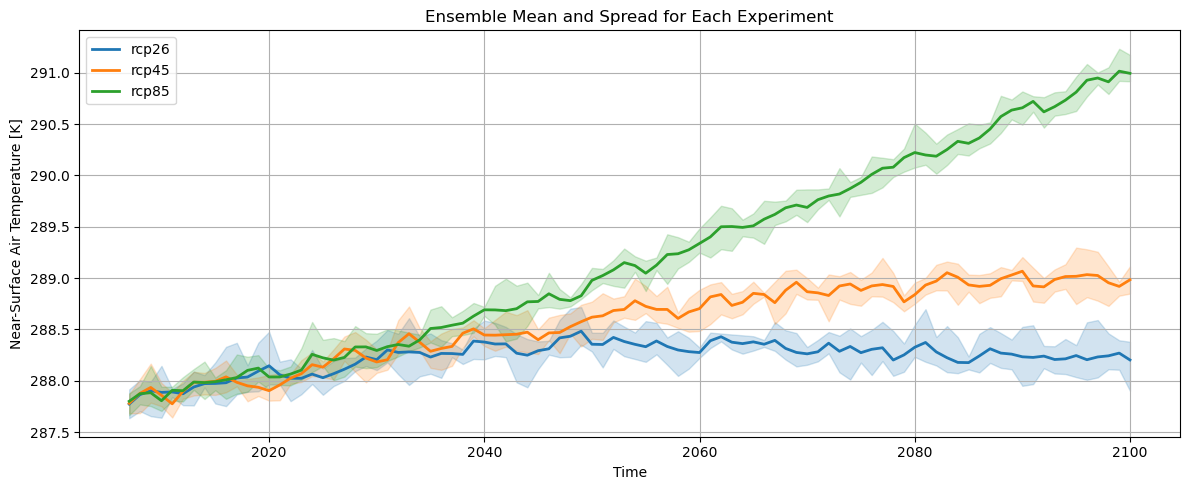

In [24]:
import matplotlib.pyplot as plt

# Create a color cycle for different experiments
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.figure(figsize=(12, 5))

for i, exp in enumerate(data.experiment.values):
    ts = data.sel(experiment=exp).resample(time="1YE").mean()
    ts_min = ts.min(dim="ensemble").squeeze()
    ts_max = ts.max(dim="ensemble").squeeze()
    ts_mean = ts.mean(dim="ensemble").squeeze()
    # Plot min–max shading
    plt.fill_between(
        ts.time,
        ts_min,
        ts_max,
        color=colors[i % len(colors)],
        alpha=0.2,
        label=None,
    )
    # Plot mean line
    plt.plot(
        ts.time,
        ts_mean,
        color=colors[i % len(colors)],
        linewidth=2,
        label=f"{exp}"
    )

# Add plot decorations
plt.title("Ensemble Mean and Spread for Each Experiment")
plt.xlabel("Time")
plt.ylabel(f"{data.attrs['long_name']} [{data.attrs['units']}]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Creating dataset catalogs:

Now that we've already found our target dataset on Freva, we may want to export the full metadata for other project's partner that might not have direct Freva access or for us to download and access it somewhere else on any other HPC system.

In this section we are going to introduce two different types of Catalogues: 
1. The [**intake-esm**](https://intake-esm.readthedocs.io/en/stable/) catalog provides a lightweight, Python-friendly interface to the metadata of large Earth System Model archives. By pointing to a central JSON index, it lets you discover, filter, and load climate model outputs—such as temperature, precipitation, or ocean variables—without downloading entire datasets. The catalog structure follows the CMIP/ESM conventions, enabling easy subsetting by attributes like project name, variable, experiment, and time period. Once exported as a standalone YAML file, your subsetted catalog can be shared with collaborators who can query and load data locally, with no direct access to the original archive required.


2. The [**STAC (SpatioTemporal Asset Catalog)**](https://stacspec.org/en) static catalog defines a simple, filesystem-based layout for geospatial metadata. A static catalog bundles Catalog, Collection, and Item JSON files into a set of directories that mirror your data hierarchy, with no dynamic search API. Bundling the entire catalog into a ZIP archive makes it trivial to distribute or archive a snapshot of your dataset inventory—satellite imagery, climate projections, or any spatiotemporal assets—for offline use, disaster recovery, or reproducible analyses. Once unzipped, the folder structure and JSON files provide the same discovery semantics as a live STAC endpoint.  


First, we’ll use **intake-esm** to subset by our chosen search keys-value pairs:  
- project: `mpi-ge`
- variable: `tas`
- time_frequency: `mon`
- time: `'2025-01 to 2100-12'`
- experiment: `picontrol`

In [2]:
db = databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12", experiment="picontrol")

In [34]:
db.intake_catalogue()

,unique
file,2
project,1
product,1
institute,1
model,1
experiment,1
time_frequency,1
realm,1
variable,1
ensemble,1


We can then export the catalogue as e.g. JSON:

In [4]:
cat = db.intake_catalogue()
cat.serialize(
    name="intake_catalog",
    directory=".",
    catalog_type="file"
)

Successfully wrote ESM catalog json file to: file:///home/k/k204229/data_search_workshop_2025-bk/intake_catalog.json


<br>

We’ll now perform the same operation on a **STAC static catalog**: download the entire catalog as a ZIP archive so you can share or inspect it offline.


In [27]:
db.stac_catalogue()

Downloading the STAC catalog started ...

'STAC catalog saved to: /home/k/k204229/data_search_workshop_2025-bk/stac-catalog-Dataset-freva-62461c2b-9a4-file.zip (size: 0.01 MB). Or simply download from: http://nextgems.dkrz.de:7777/api/freva-nextgen/databrowser/stac-catalogue/freva/file?multi-version=False&project=mpi-ge&variable=tas&time_frequency=mon&experiment=picontrol&time=2025-01+to+2100-12&time_select=flexible'

<br>

To complete our explanation about STAC catalog, the **STAC static catalog** is implemented as a set of flat files on a web server or object store (e.g., S3). It exposes the same Item, Catalog, and Collection JSON structure as a dynamic STAC, but without a `/search` endpoint—making it easy to bundle and distribute as a ZIP for disaster recovery or offline use.